<a href="https://colab.research.google.com/github/username/detection-of-anthropogenic-river-avulsion/blob/main/notebooks/03_analysis_meijering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis: Ghost River Detection via NDRE & Meijering Filter

This notebook demonstrates the detection of the Iput River avulsion ('Ghost River') using Sentinel-2 Red Edge spectral indices and structural filtering.

**Methodology:**
1.  **Calculate NDRE**: Normalized Difference Red Edge index using Bands 05 and 08.
2.  **Vegetation Extraction**: Isolate the 'Green Strip' of dense vegetation that occupies the paleochannel.
3.  **Contrast Enhancement**: Improve the visibility of the features.
4.  **Structure Detection**: Apply Meijering/Frangi vesselness filters to detect the river-like morphology.

In [2]:
import sys
import os
from pathlib import Path
import rasterio
import rasterio.enums
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

# --- Colab Support ---
try:
    from google.colab import drive
    print("Running in Google Colab")

    # Clone repo if strictly needed, or just set path if already there
    if not os.path.exists('detection-of-anthropogenic-river-avulsion'):
        !git clone https://github.com/archerby/detection-of-anthropogenic-river-avulsion.git
    else:
        %cd detection-of-anthropogenic-river-avulsion
        !git pull
        %cd ..

    # Add project root to sys.path
    project_root = '/content/detection-of-anthropogenic-river-avulsion'
    if project_root not in sys.path:
        sys.path.append(project_root)

    # Switch to src directory to ensure imports work if they depend on local files
    src_path = os.path.join(project_root, 'src')
    if src_path not in sys.path:
        sys.path.append(src_path)

except ImportError:
    print("Running Locally")
    # Add src to path (local fallback)
    sys.path.append(os.path.abspath("../src"))

from filters import apply_structure_detection
from visualization import plot_structure_composite

Running in Google Colab
/content/detection-of-anthropogenic-river-avulsion
Already up to date.
/content


## 1. Load Data

Loading bands:
 /content/detection-of-anthropogenic-river-avulsion/data/sample/dobrush_B05.tif
 /content/detection-of-anthropogenic-river-avulsion/data/sample/dobrush_B08.tif
Resampled B05 to (946, 1402) to match B08 (946, 1402)
NDRE Calculated. Shape: (946, 1402), Range: -0.49 to 0.55


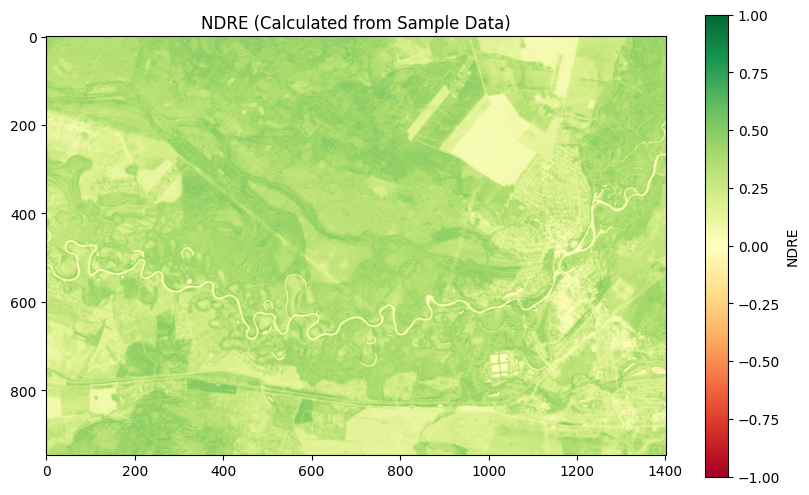

In [4]:
# Load Sentinel-2 Sample (B05, B08) from Repo
b05_path = "/content/detection-of-anthropogenic-river-avulsion/data/sample/dobrush_B05.tif"
b08_path = "/content/detection-of-anthropogenic-river-avulsion/data/sample/dobrush_B08.tif"

print(f"Loading bands:\n {b05_path}\n {b08_path}")

try:
    # 1. Load Reference Band (B08 - 10m Resolution)
    with rasterio.open(b08_path) as src_b08:
        b08 = src_b08.read(1).astype('float32')
        ref_meta = src_b08.meta
        height, width = b08.shape

    # 2. Load and Resample Target Band (B05 - 20m Resolution) to match B08
    with rasterio.open(b05_path) as src_b05:
        b05 = src_b05.read(
            1,
            out_shape=(height, width),
            resampling=rasterio.enums.Resampling.bilinear
        ).astype('float32')

    print(f"Resampled B05 to {b05.shape} to match B08 {b08.shape}")

    # Calculate NDRE: (B08 - B05) / (B08 + B05)
    numerator = b08 - b05
    denominator = b08 + b05

    # Handle division by zero
    ndre = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)

    print(f"NDRE Calculated. Shape: {ndre.shape}, Range: {np.min(ndre):.2f} to {np.max(ndre):.2f}")

    plt.figure(figsize=(10, 6))
    plt.imshow(ndre, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label='NDRE')
    plt.title("NDRE (Calculated from Sample Data)")
    plt.show()

except Exception as e:
    print(f"Error loading data: {e}")
    path = os.getcwd()
    print(f"Current CWD: {path}")
    # Print available files to help debug path issues
    try:
        print(f"Files in ../data/sample: {os.listdir('../data/sample')}")
    except:
        print("Could not list ../data/sample")
    raise e


## 2. Vegetation Extraction & Contrast Enhancement
We focus on the "Green Strip" - the paleo-channel is often characterized by denser vegetation (high NDRE) compared to fields.

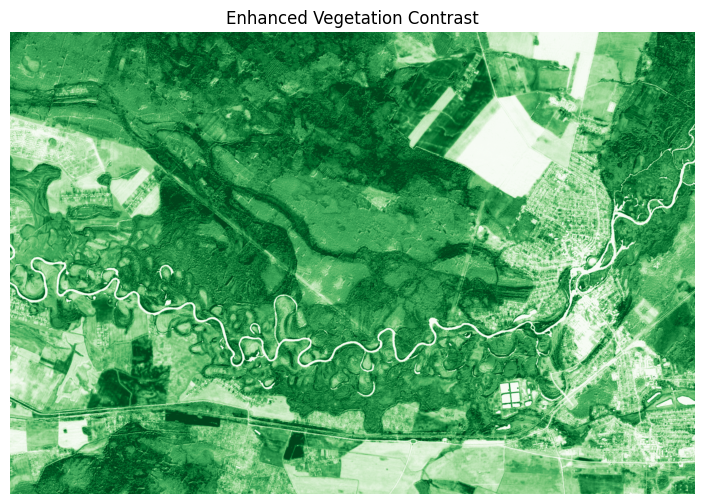

In [5]:
# Enhance contrast for the 'Green Strip'
# Standard linear rescaling for best results on this dataset
p2, p98 = np.percentile(ndre, (2, 98))
ndre_rescaled = exposure.rescale_intensity(ndre, in_range=(p2, p98))

plt.figure(figsize=(10, 6))
plt.imshow(ndre_rescaled, cmap='Greens')
plt.title("Enhanced Vegetation Contrast")
plt.axis('off')
plt.show()

## 3. Structural Detection (Meijering/Frangi)
We apply the vesselness filter to detect linear, continuous structures (paleo-channels) within the vegetation map.

### Parameters:
*   **sigmas**: Controls the scale (thickness) of detected features. Larger sigma values (e.g., 5-10) detect thicker rivers.
*   **method**: 'meijering'. Proven best for continuous ridges in this area.


In [6]:
# Apply Filter to Enhanced NDRE
# Sigmas 2-12 for thicker features

bright_norm, dark_norm = apply_structure_detection(
    ndre_rescaled,
    clip_max=1.0,
    sigmas=range(2, 12, 2),
    method='meijering'
)

print("Filter Complete.")

Filter Complete.


## 4. Final Visualization
Composite of the original signal and the detected 'Veins' (channel).

**Tuning (User Approved):**
*   **Red / Bright Ridges**: Threshold lowered to **70th percentile** to highlight major features.
*   **Blue / Dark Ridges**: Threshold raised to **95th percentile** to reduce noise.

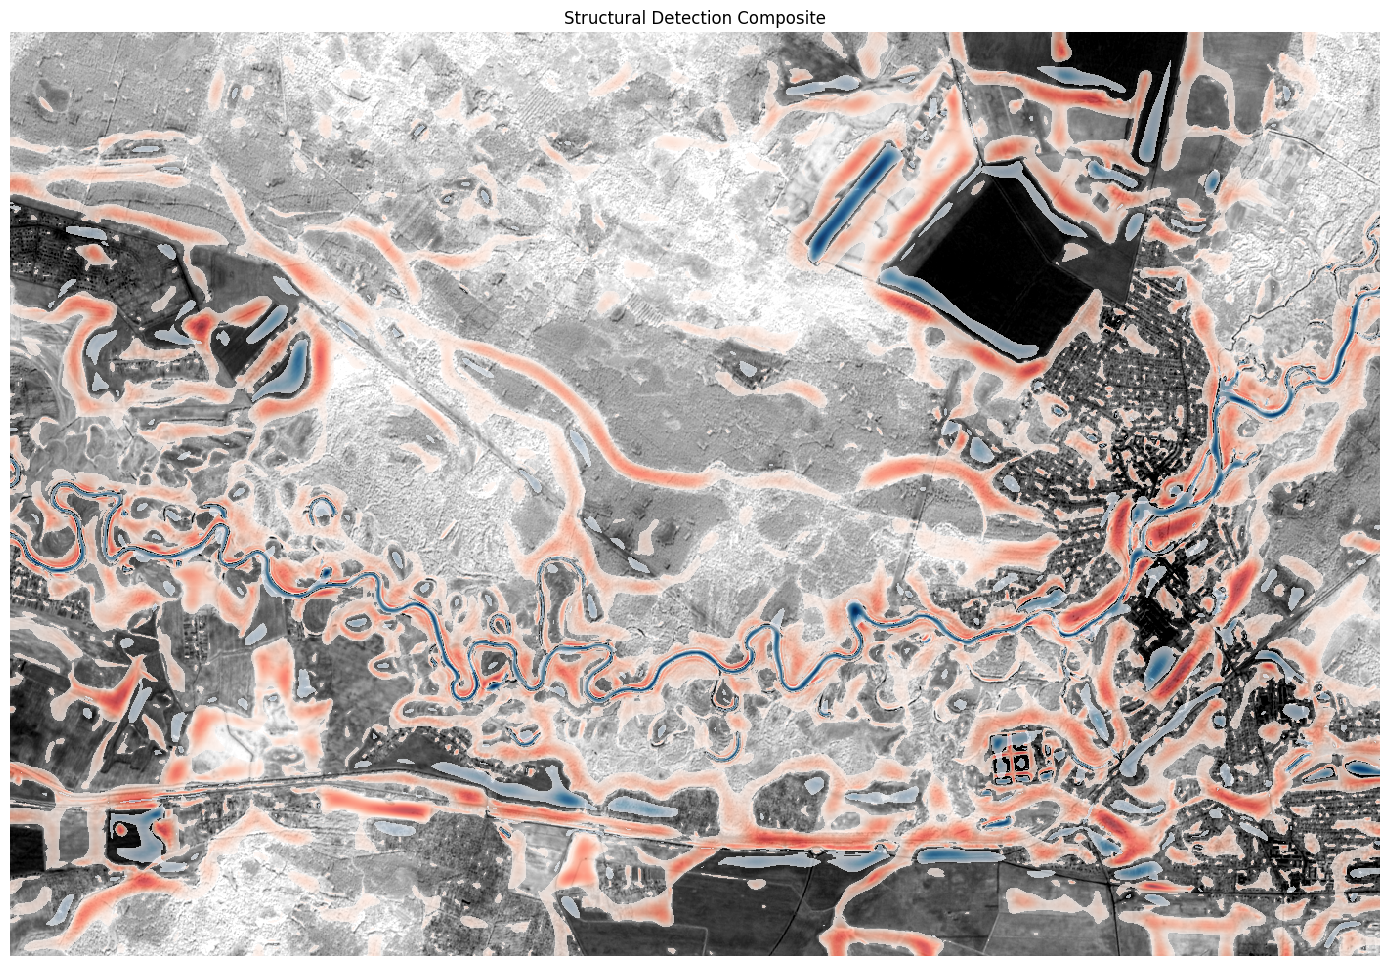

Final result saved to final_detection_result.png


In [7]:
# Visualize with tuned thresholds
output_path = "final_detection_result.png"
plot_structure_composite(ndre, bright_norm, dark_norm, output_path=output_path, percentiles=(70, 95))
print(f"Final result saved to {output_path}")